# League of Legends Meta Analysis - Machine Learning

## Projet d'analyse de la méta et prédiction de victoire

**Objectif** : Maximiser les chances de victoire dans League of Legends en s'appuyant sur l'analyse des données et des modèles de machine learning.

**Approche** : 
- Analyser la méta actuelle (champions, items)
- Optimiser les builds et performances
- Développer des stratégies de draft (picks/bans)
- Prédire l'issue des parties

---

Ce notebook suit le plan d'action détaillé et implémente chaque phase progressivement.

# Phase 0 — Préparation et Qualité des Données

## Objectifs de cette phase :
1. **Rassembler et contrôler** : Charger tous les fichiers CSV du dataset
2. **Nettoyer** : Gérer les IDs anormaux, valeurs manquantes, données corrompues
3. **Échantillonner** : Séparer les différents types de parties (ARAM vs CLASSIC, classé vs non classé)
4. **Définir les jeux** : Créer les ensembles train/validation/test par chronologie de patch

**Pourquoi cette phase est cruciale ?**
- La qualité des données impacte directement la fiabilité des modèles
- Un nettoyage rigoureux évite les biais et erreurs de prédiction
- Une séparation temporelle (par patch) évite le "data leakage" et garantit que notre modèle peut généraliser sur des données futures

## 0.1 - Import des bibliothèques

**Bibliothèques nécessaires :**
- **pandas** : Manipulation et analyse de données tabulaires
- **numpy** : Calculs numériques et opérations sur tableaux
- **matplotlib/seaborn** : Visualisations statistiques
- **sklearn** : Préparation des données et modélisation ML

In [15]:
# Import des bibliothèques essentielles
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path

# Configuration
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("Bibliothèques importées avec succès!")
print(f"Version pandas: {pd.__version__}")
print(f"Version numpy: {np.__version__}")

Bibliothèques importées avec succès!
Version pandas: 2.3.3
Version numpy: 2.3.4


## 0.2 - Chargement des données

**Structure du dataset :**
- **ChampionTbl.csv** : Table de référence des champions (175 champions)
- **ItemTbl.csv** : Table de référence des items (637 objets)
- **RankTbl.csv** : Table de référence des rangs (11 niveaux)
- **MatchTbl.csv** : Table des matchs (110,479 matchs)
- **SummonerMatchTbl.csv** : Association joueur-match-champion (223,154 enregistrements)
- **MatchStatsTbl.csv** : Statistiques détaillées par joueur (223,154 enregistrements)
- **TeamMatchTbl.csv** : Statistiques par équipe (97,885 enregistrements)

**Pourquoi charger toutes les tables ?**
Ces tables sont reliées entre elles (base de données relationnelle). Nous aurons besoin de faire des jointures pour enrichir nos analyses et créer des features pertinentes pour nos modèles.

In [16]:
# Définir le chemin vers le dataset
dataset_path = Path("../Dataset")

# Charger toutes les tables
print("🔄 Chargement des tables...")

# Tables de référence (lookup tables)
champions_df = pd.read_csv(dataset_path / "ChampionTbl.csv")
items_df = pd.read_csv(dataset_path / "ItemTbl.csv")
ranks_df = pd.read_csv(dataset_path / "RankTbl.csv")

# Tables de faits (fact tables)
matches_df = pd.read_csv(dataset_path / "MatchTbl.csv")
summoner_match_df = pd.read_csv(dataset_path / "SummonerMatchTbl.csv")
match_stats_df = pd.read_csv(dataset_path / "MatchStatsTbl.csv")
team_match_df = pd.read_csv(dataset_path / "TeamMatchTbl.csv")

print("✅ Toutes les tables chargées!\n")

# Afficher les dimensions
tables = {
    "Champions": champions_df,
    "Items": items_df,
    "Ranks": ranks_df,
    "Matches": matches_df,
    "SummonerMatch": summoner_match_df,
    "MatchStats": match_stats_df,
    "TeamMatch": team_match_df
}

print("📊 Dimensions des tables:")
print("-" * 50)
for name, df in tables.items():
    print(f"{name:20} : {df.shape[0]:>8} lignes × {df.shape[1]:>2} colonnes")
    
print(f"\n💾 Mémoire totale utilisée: {sum(df.memory_usage(deep=True).sum() for df in tables.values()) / 1024**2:.2f} MB")

🔄 Chargement des tables...
✅ Toutes les tables chargées!

📊 Dimensions des tables:
--------------------------------------------------
Champions            :      173 lignes ×  2 colonnes
Items                :      635 lignes ×  2 colonnes
Ranks                :       11 lignes ×  2 colonnes
Matches              :   110477 lignes ×  5 colonnes
SummonerMatch        :   223152 lignes ×  4 colonnes
MatchStats           :   223152 lignes × 31 colonnes
TeamMatch            :    97883 lignes × 24 colonnes

💾 Mémoire totale utilisée: 125.35 MB


## 0.3 - Exploration initiale des données

**Objectif :** Comprendre la structure, les types de données et détecter les premières anomalies.

**Ce que nous allons vérifier :**
- Types de données de chaque colonne
- Valeurs manquantes (NaN)
- Valeurs uniques et distribution
- Cohérence des clés étrangères

In [17]:
# Fonction helper pour explorer une table
def explore_table(df, name):
    print(f"\n{'='*60}")
    print(f"📋 TABLE: {name}")
    print('='*60)
    
    # Aperçu
    print("\n🔍 Aperçu des premières lignes:")
    display(df.head(3))
    
    # Informations sur les colonnes
    print(f"\n📊 Informations sur les colonnes:")
    print(df.info())
    
    # Valeurs manquantes
    missing = df.isnull().sum()
    if missing.sum() > 0:
        print(f"\n⚠️  Valeurs manquantes détectées:")
        print(missing[missing > 0])
    else:
        print(f"\n✅ Aucune valeur manquante détectée")
    
    return df

# Explorer les tables de référence (plus petites)
print("="*60)
print("🔎 EXPLORATION DES TABLES DE RÉFÉRENCE")
print("="*60)

explore_table(champions_df, "ChampionTbl")
explore_table(items_df, "ItemTbl") 
explore_table(ranks_df, "RankTbl")

🔎 EXPLORATION DES TABLES DE RÉFÉRENCE

📋 TABLE: ChampionTbl

🔍 Aperçu des premières lignes:


,ChampionId,ChampionName
0,0,No Champion
1,1,Annie
2,2,Olaf



📊 Informations sur les colonnes:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173 entries, 0 to 172
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ChampionId    173 non-null    int64 
 1   ChampionName  173 non-null    object
dtypes: int64(1), object(1)
memory usage: 2.8+ KB
None

✅ Aucune valeur manquante détectée

📋 TABLE: ItemTbl

🔍 Aperçu des premières lignes:


,ItemID,ItemName
0,1001,Boots
1,1004,Faerie Charm
2,1006,Rejuvenation Bead



📊 Informations sur les colonnes:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 635 entries, 0 to 634
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ItemID    635 non-null    int64 
 1   ItemName  635 non-null    object
dtypes: int64(1), object(1)
memory usage: 10.1+ KB
None

✅ Aucune valeur manquante détectée

📋 TABLE: RankTbl

🔍 Aperçu des premières lignes:


,RankId,RankName
0,0,Unranked
1,1,Iron
2,2,Bronze



📊 Informations sur les colonnes:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   RankId    11 non-null     int64 
 1   RankName  11 non-null     object
dtypes: int64(1), object(1)
memory usage: 308.0+ bytes
None

✅ Aucune valeur manquante détectée


,RankId,RankName
0,0,Unranked
1,1,Iron
2,2,Bronze
3,3,Silver
4,4,Gold
5,5,Platinum
6,6,Emerald
7,7,Diamond
8,8,Master
9,9,Grandmaster


In [18]:
# Explorer MatchTbl (table centrale)
print("\n" + "="*60)
print("🔎 EXPLORATION DE LA TABLE CENTRALE DES MATCHS")
print("="*60)

explore_table(matches_df, "MatchTbl")

# Analyses spécifiques pour MatchTbl
print("\n📊 Analyses complémentaires pour MatchTbl:")
print("-" * 60)

# Distribution des types de queue
print("\n🎮 Distribution des modes de jeu:")
print(matches_df['QueueType'].value_counts())

# Distribution des ranks
print("\n🏆 Distribution des ranks:")
rank_dist = matches_df['RankFk'].value_counts().sort_index()
print(rank_dist)

# Statistiques sur les patches
print("\n🔧 Statistiques sur les patches:")
print(f"Nombre de patches différents: {matches_df['Patch'].nunique()}")
print("\nTop 10 patches les plus fréquents:")
print(matches_df['Patch'].value_counts().head(10))

# Durée des matchs
print("\n⏱️  Statistiques sur la durée des matchs:")
print(f"Durée min: {matches_df['GameDuration'].min()} sec ({matches_df['GameDuration'].min()/60:.1f} min)")
print(f"Durée max: {matches_df['GameDuration'].max()} sec ({matches_df['GameDuration'].max()/60:.1f} min)")
print(f"Durée moyenne: {matches_df['GameDuration'].mean():.0f} sec ({matches_df['GameDuration'].mean()/60:.1f} min)")
print(f"Durée médiane: {matches_df['GameDuration'].median():.0f} sec ({matches_df['GameDuration'].median()/60:.1f} min)")


🔎 EXPLORATION DE LA TABLE CENTRALE DES MATCHS

📋 TABLE: MatchTbl

🔍 Aperçu des premières lignes:


,MatchId,Patch,QueueType,RankFk,GameDuration
0,EUN1_3707659547,14.23.636.9832,ARAM,0,1173
1,EUN1_3709211408,14.24.642.1879,CLASSIC,0,1986
2,EUN1_3710823249,14.24.643.5128,ARAM,0,813



📊 Informations sur les colonnes:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110477 entries, 0 to 110476
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   MatchId       110477 non-null  object
 1   Patch         110477 non-null  object
 2   QueueType     110477 non-null  object
 3   RankFk        110477 non-null  int64 
 4   GameDuration  110477 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 4.2+ MB
None

✅ Aucune valeur manquante détectée

📊 Analyses complémentaires pour MatchTbl:
------------------------------------------------------------

🎮 Distribution des modes de jeu:
QueueType
CLASSIC      83062
CHERRY       13232
ARAM         11979
SWIFTPLAY     2190
ULTBOOK         14
Name: count, dtype: int64

🏆 Distribution des ranks:
RankFk
0     13283
1      1666
2      3559
3      9702
4     15654
5     17487
6     13748
7      9913
8     23254
9      1830
10      381
Name: count, dtype: int64

🔧 

In [19]:
# Explorer MatchStatsTbl (statistiques détaillées)
print("\n" + "="*60)
print("🔎 EXPLORATION DES STATISTIQUES DE MATCH")
print("="*60)

print(f"\n📋 Aperçu de MatchStatsTbl:")
print(f"Dimensions: {match_stats_df.shape[0]} lignes × {match_stats_df.shape[1]} colonnes")
display(match_stats_df.head(3))

print(f"\n📊 Info sur les colonnes:")
match_stats_df.info()

# Vérifier les valeurs manquantes
missing_stats = match_stats_df.isnull().sum()
if missing_stats.sum() > 0:
    print(f"\n⚠️  Valeurs manquantes:")
    print(missing_stats[missing_stats > 0])
else:
    print(f"\n✅ Aucune valeur manquante")

# Statistiques sur les performances
print(f"\n📈 Statistiques de performance clés:")
key_metrics = ['MinionsKilled', 'TotalGold', 'DmgDealt', 'DmgTaken', 'kills', 'deaths', 'assists', 'visionScore']
display(match_stats_df[key_metrics].describe())


🔎 EXPLORATION DES STATISTIQUES DE MATCH

📋 Aperçu de MatchStatsTbl:
Dimensions: 223152 lignes × 31 colonnes


,MatchStatsId,SummonerMatchFk,MinionsKilled,DmgDealt,DmgTaken,TurretDmgDealt,TotalGold,Lane,Win,item1,item2,item3,item4,item5,item6,kills,deaths,assists,PrimaryKeyStone,PrimarySlot1,PrimarySlot2,PrimarySlot3,SecondarySlot1,SecondarySlot2,SummonerSpell1,SummonerSpell2,CurrentMasteryPoints,EnemyChampionFk,DragonKills,BaronKills,visionScore
0,1,1,30,4765,12541,0,7058,BOTTOM,0,3870,2055,3107,3171,6620,2022,0,2,12,8465,8463,8473,8453,8345,8347,4,7,902,51,0,0,67
1,2,2,29,8821,14534,1,9618,BOTTOM,0,3870,2065,3107,3158,6620,3916,2,5,23,8465,8463,8473,8453,8345,8347,4,7,902,236,0,0,88
2,3,3,34,6410,19011,3,9877,BOTTOM,1,3870,3107,1011,3171,6617,3916,0,5,22,8214,8226,8210,8237,8345,8347,4,7,16,498,0,0,97



📊 Info sur les colonnes:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223152 entries, 0 to 223151
Data columns (total 31 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   MatchStatsId          223152 non-null  int64 
 1   SummonerMatchFk       223152 non-null  int64 
 2   MinionsKilled         223152 non-null  int64 
 3   DmgDealt              223152 non-null  int64 
 4   DmgTaken              223152 non-null  int64 
 5   TurretDmgDealt        223152 non-null  int64 
 6   TotalGold             223152 non-null  int64 
 7   Lane                  223152 non-null  object
 8   Win                   223152 non-null  int64 
 9   item1                 223152 non-null  int64 
 10  item2                 223152 non-null  int64 
 11  item3                 223152 non-null  int64 
 12  item4                 223152 non-null  int64 
 13  item5                 223152 non-null  int64 
 14  item6                 223152 non-null  int

,MinionsKilled,TotalGold,DmgDealt,DmgTaken,kills,deaths,assists,visionScore
count,223152.000000,223152.000000,223152.000000,223152.000000,223152.000000,223152.000000,223152.000000,223152.000000
mean,109.153151,12201.354297,25031.880915,29752.300804,6.723390,6.493771,9.674711,19.934569
std,90.351549,4576.636754,17289.015608,17775.488384,5.370145,3.709818,8.701130,22.333798
min,0.000000,500.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,24.000000,9212.000000,13134.000000,18554.000000,3.000000,4.000000,4.000000,4.000000
50%,99.000000,11895.000000,21541.000000,26559.000000,6.000000,6.000000,7.000000,15.000000
75%,188.000000,14867.000000,32514.000000,37214.000000,10.000000,9.000000,13.000000,25.000000
max,549.000000,56281.000000,314904.000000,435808.000000,54.000000,46.000000,92.000000,215.000000


## 0.4 - Détection et nettoyage des anomalies

**Anomalies identifiées dans la documentation :**
1. **IDs de champions anormaux** : Certains ChampionIds très élevés (>200,000) ne correspondent pas à ChampionTbl
2. **IDs d'items invalides** : Certains ItemIds ne correspondent pas à ItemTbl  
3. **Runes à 0** : PrimaryKeyStone=0 est impossible en réalité (données manquantes)
4. **Sorts d'invocateur à 0** : Invalide en jeu normal

**Plan de nettoyage :**
- Identifier les IDs invalides en croisant avec les tables de référence
- Décider de la stratégie : suppression ou imputation selon le % d'anomalies
- Créer une version "clean" du dataset pour les analyses

In [6]:
# Créer des sets de valeurs valides
valid_champion_ids = set(champions_df['ChampionId'].values)
valid_item_ids = set(items_df['ItemID'].values)
valid_match_ids = set(matches_df['MatchId'].values)

print("🔍 Détection des anomalies...")
print("=" * 60)

# 1. Vérifier les ChampionIds dans SummonerMatchTbl
print("\n1️⃣ Vérification des ChampionIds dans SummonerMatchTbl:")
invalid_champions_sm = summoner_match_df[~summoner_match_df['ChampionFk'].isin(valid_champion_ids)]
print(f"   Enregistrements avec ChampionId invalide: {len(invalid_champions_sm)} ({len(invalid_champions_sm)/len(summoner_match_df)*100:.2f}%)")
if len(invalid_champions_sm) > 0:
    print(f"   Champions invalides uniques: {invalid_champions_sm['ChampionFk'].nunique()}")
    print(f"   Exemples: {invalid_champions_sm['ChampionFk'].unique()[:10]}")

# 2. Vérifier les ChampionIds dans MatchStatsTbl (EnemyChampionFk)
print("\n2️⃣ Vérification des EnemyChampionFk dans MatchStatsTbl:")
invalid_enemy_champs = match_stats_df[~match_stats_df['EnemyChampionFk'].isin(valid_champion_ids)]
print(f"   Enregistrements avec EnemyChampionFk invalide: {len(invalid_enemy_champs)} ({len(invalid_enemy_champs)/len(match_stats_df)*100:.2f}%)")

# 3. Vérifier les Items dans MatchStatsTbl
print("\n3️⃣ Vérification des Items dans MatchStatsTbl:")
item_cols = ['item1', 'item2', 'item3', 'item4', 'item5', 'item6']
invalid_items_count = 0
for col in item_cols:
    # Filtrer les 0 (slots vides) qui sont valides
    non_zero_items = match_stats_df[match_stats_df[col] != 0]
    invalid = non_zero_items[~non_zero_items[col].isin(valid_item_ids)]
    invalid_items_count += len(invalid)
    if len(invalid) > 0:
        print(f"   {col}: {len(invalid)} items invalides ({len(invalid)/len(non_zero_items)*100:.2f}%)")

print(f"   Total d'items invalides (non-zéro): {invalid_items_count}")

# 4. Vérifier les runes à 0
print("\n4️⃣ Vérification des runes (PrimaryKeyStone):")
zero_runes = match_stats_df[match_stats_df['PrimaryKeyStone'] == 0]
print(f"   Enregistrements avec PrimaryKeyStone=0: {len(zero_runes)} ({len(zero_runes)/len(match_stats_df)*100:.2f}%)")

# 5. Vérifier les sorts d'invocateur à 0
print("\n5️⃣ Vérification des sorts d'invocateur:")
zero_spell1 = match_stats_df[match_stats_df['SummonerSpell1'] == 0]
zero_spell2 = match_stats_df[match_stats_df['SummonerSpell2'] == 0]
print(f"   SummonerSpell1=0: {len(zero_spell1)} ({len(zero_spell1)/len(match_stats_df)*100:.2f}%)")
print(f"   SummonerSpell2=0: {len(zero_spell2)} ({len(zero_spell2)/len(match_stats_df)*100:.2f}%)")

# 6. Vérifier les champions dans TeamMatchTbl
print("\n6️⃣ Vérification des compositions dans TeamMatchTbl:")
team_champ_cols = ['B1Champ', 'B2Champ', 'B3Champ', 'B4Champ', 'B5Champ', 
                   'R1Champ', 'R2Champ', 'R3Champ', 'R4Champ', 'R5Champ']
invalid_team_champs = 0
for col in team_champ_cols:
    invalid = team_match_df[~team_match_df[col].isin(valid_champion_ids)]
    invalid_team_champs += len(invalid)
    if len(invalid) > 0:
        print(f"   {col}: {len(invalid)} champions invalides")

print(f"   Total de champions invalides dans les compositions: {invalid_team_champs}")

🔍 Détection des anomalies...

1️⃣ Vérification des ChampionIds dans SummonerMatchTbl:
   Enregistrements avec ChampionId invalide: 0 (0.00%)

2️⃣ Vérification des EnemyChampionFk dans MatchStatsTbl:
   Enregistrements avec EnemyChampionFk invalide: 0 (0.00%)

3️⃣ Vérification des Items dans MatchStatsTbl:
   item5: 2 items invalides (0.00%)
   Total d'items invalides (non-zéro): 2

4️⃣ Vérification des runes (PrimaryKeyStone):
   Enregistrements avec PrimaryKeyStone=0: 26964 (12.08%)

5️⃣ Vérification des sorts d'invocateur:
   SummonerSpell1=0: 0 (0.00%)
   SummonerSpell2=0: 0 (0.00%)

6️⃣ Vérification des compositions dans TeamMatchTbl:
   Total de champions invalides dans les compositions: 0


In [7]:
# Application du nettoyage
print("\n🧹 Application du nettoyage des données...")
print("=" * 60)

# Copier les dataframes pour garder les originaux
summoner_match_clean = summoner_match_df.copy()
match_stats_clean = match_stats_df.copy()
team_match_clean = team_match_df.copy()

# Compteurs de nettoyage
cleaning_summary = {
    'summoner_match_removed': 0,
    'match_stats_removed': 0,
    'team_match_removed': 0,
    'runes_to_nan': 0,
    'spells_to_nan': 0,
    'items_to_nan': 0
}

# 1. Nettoyer SummonerMatchTbl - Supprimer les champions invalides
print("\n1️⃣ Nettoyage de SummonerMatchTbl:")
before = len(summoner_match_clean)
summoner_match_clean = summoner_match_clean[summoner_match_clean['ChampionFk'].isin(valid_champion_ids)]
cleaning_summary['summoner_match_removed'] = before - len(summoner_match_clean)
print(f"   ✅ {cleaning_summary['summoner_match_removed']} enregistrements supprimés ({cleaning_summary['summoner_match_removed']/before*100:.2f}%)")

# 2. Nettoyer MatchStatsTbl - Runes à 0 → NaN
print("\n2️⃣ Nettoyage des runes dans MatchStatsTbl:")
rune_cols = ['PrimaryKeyStone', 'PrimarySlot1', 'PrimarySlot2', 'PrimarySlot3', 'SecondarySlot1', 'SecondarySlot2']
for col in rune_cols:
    count = (match_stats_clean[col] == 0).sum()
    match_stats_clean.loc[match_stats_clean[col] == 0, col] = np.nan
    cleaning_summary['runes_to_nan'] += count
print(f"   ✅ {cleaning_summary['runes_to_nan']} valeurs de runes converties en NaN")

# 3. Nettoyer MatchStatsTbl - Sorts d'invocateur à 0 → NaN
print("\n3️⃣ Nettoyage des sorts d'invocateur dans MatchStatsTbl:")
spell_cols = ['SummonerSpell1', 'SummonerSpell2']
for col in spell_cols:
    count = (match_stats_clean[col] == 0).sum()
    match_stats_clean.loc[match_stats_clean[col] == 0, col] = np.nan
    cleaning_summary['spells_to_nan'] += count
print(f"   ✅ {cleaning_summary['spells_to_nan']} valeurs de sorts converties en NaN")

# 4. Nettoyer les items invalides (non-zéro et non-valides) → NaN
print("\n4️⃣ Nettoyage des items invalides dans MatchStatsTbl:")
for col in item_cols:
    # Identifier les items invalides (non-zéro ET non dans la liste valide)
    invalid_mask = (match_stats_clean[col] != 0) & (~match_stats_clean[col].isin(valid_item_ids))
    count = invalid_mask.sum()
    match_stats_clean.loc[invalid_mask, col] = np.nan
    cleaning_summary['items_to_nan'] += count
print(f"   ✅ {cleaning_summary['items_to_nan']} items invalides convertis en NaN")

# 5. Nettoyer TeamMatchTbl - Supprimer les lignes avec champions invalides
print("\n5️⃣ Nettoyage de TeamMatchTbl:")
before = len(team_match_clean)
valid_mask = True
for col in team_champ_cols:
    valid_mask &= team_match_clean[col].isin(valid_champion_ids)
team_match_clean = team_match_clean[valid_mask]
cleaning_summary['team_match_removed'] = before - len(team_match_clean)
print(f"   ✅ {cleaning_summary['team_match_removed']} enregistrements supprimés ({cleaning_summary['team_match_removed']/before*100:.2f}%)")

# Résumé final
print("\n" + "=" * 60)
print("📊 RÉSUMÉ DU NETTOYAGE")
print("=" * 60)
print(f"\nSummonerMatchTbl: {len(summoner_match_df):,} → {len(summoner_match_clean):,} (-{cleaning_summary['summoner_match_removed']:,})")
print(f"MatchStatsTbl: {len(match_stats_df):,} lignes conservées")
print(f"  - Runes converties en NaN: {cleaning_summary['runes_to_nan']:,}")
print(f"  - Sorts convertis en NaN: {cleaning_summary['spells_to_nan']:,}")
print(f"  - Items convertis en NaN: {cleaning_summary['items_to_nan']:,}")
print(f"TeamMatchTbl: {len(team_match_df):,} → {len(team_match_clean):,} (-{cleaning_summary['team_match_removed']:,})")

print("\n✅ Nettoyage terminé! Les dataframes '_clean' sont prêts pour l'analyse.")


🧹 Application du nettoyage des données...

1️⃣ Nettoyage de SummonerMatchTbl:
   ✅ 0 enregistrements supprimés (0.00%)

2️⃣ Nettoyage des runes dans MatchStatsTbl:
   ✅ 161784 valeurs de runes converties en NaN

3️⃣ Nettoyage des sorts d'invocateur dans MatchStatsTbl:
   ✅ 0 valeurs de sorts converties en NaN

4️⃣ Nettoyage des items invalides dans MatchStatsTbl:
   ✅ 2 items invalides convertis en NaN

5️⃣ Nettoyage de TeamMatchTbl:
   ✅ 0 enregistrements supprimés (0.00%)

📊 RÉSUMÉ DU NETTOYAGE

SummonerMatchTbl: 223,152 → 223,152 (-0)
MatchStatsTbl: 223,152 lignes conservées
  - Runes converties en NaN: 161,784
  - Sorts convertis en NaN: 0
  - Items convertis en NaN: 2
TeamMatchTbl: 97,883 → 97,883 (-0)

✅ Nettoyage terminé! Les dataframes '_clean' sont prêts pour l'analyse.


## 0.5 - Échantillonnage et segmentation

**Objectif :** Séparer les données selon différents critères pour des analyses ciblées.

**Segmentations importantes :**
1. **Par mode de jeu** : ARAM vs CLASSIC (méta très différente)
2. **Par niveau de compétition** : Ranked (RankFk > 0) vs Unranked (RankFk = 0)
3. **Par patch** : Séparer les patches pour analyse temporelle

**Pourquoi c'est important ?**
- ARAM et CLASSIC ont des règles différentes → méta différente
- Les ranked games sont plus compétitives et représentatives
- L'analyse par patch permet de détecter l'évolution de la méta

In [8]:
# Créer les différentes segmentations
print("🎯 Création des segmentations du dataset...")
print("=" * 60)

# 1. Segmentation par mode de jeu
print("\n1️⃣ Segmentation par mode de jeu:")
aram_matches = matches_df[matches_df['QueueType'] == 'ARAM']
classic_matches = matches_df[matches_df['QueueType'] == 'CLASSIC']

print(f"   ARAM: {len(aram_matches):,} matchs ({len(aram_matches)/len(matches_df)*100:.1f}%)")
print(f"   CLASSIC: {len(classic_matches):,} matchs ({len(classic_matches)/len(matches_df)*100:.1f}%)")

# 2. Segmentation par niveau de compétition
print("\n2️⃣ Segmentation par niveau de compétition:")
unranked_matches = matches_df[matches_df['RankFk'] == 0]
ranked_matches = matches_df[matches_df['RankFk'] > 0]

print(f"   Unranked: {len(unranked_matches):,} matchs ({len(unranked_matches)/len(matches_df)*100:.1f}%)")
print(f"   Ranked: {len(ranked_matches):,} matchs ({len(ranked_matches)/len(matches_df)*100:.1f}%)")

# Distribution des ranks pour les ranked games
if len(ranked_matches) > 0:
    print("\n   📊 Distribution des ranks (pour ranked games):")
    rank_distribution = ranked_matches['RankFk'].value_counts().sort_index()
    for rank_id, count in rank_distribution.items():
        rank_name = ranks_df[ranks_df['RankId'] == rank_id]['RankName'].values[0] if rank_id in ranks_df['RankId'].values else 'Unknown'
        print(f"      {rank_name:15} (ID={rank_id}): {count:,} matchs ({count/len(ranked_matches)*100:.1f}%)")

# 3. Extraction de la version majeure du patch (ex: 14.23.636.9832 → 14.23)
print("\n3️⃣ Analyse des patches:")
matches_df['PatchMajor'] = matches_df['Patch'].str.split('.').str[:2].str.join('.')
patch_distribution = matches_df['PatchMajor'].value_counts().sort_index()

print(f"   Nombre de patches majeurs: {matches_df['PatchMajor'].nunique()}")
print(f"\n   Top 10 patches majeurs:")
for patch, count in patch_distribution.head(10).items():
    print(f"      Patch {patch}: {count:,} matchs ({count/len(matches_df)*100:.1f}%)")

# 4. Catégorisation par durée de partie
print("\n4️⃣ Catégorisation par durée de partie:")
matches_df['DurationCategory'] = pd.cut(
    matches_df['GameDuration'] / 60,  # Convertir en minutes
    bins=[0, 20, 30, float('inf')],
    labels=['Courte (<20min)', 'Standard (20-30min)', 'Longue (>30min)']
)

duration_dist = matches_df['DurationCategory'].value_counts()
for category, count in duration_dist.items():
    print(f"   {category}: {count:,} matchs ({count/len(matches_df)*100:.1f}%)")

print("\n✅ Segmentations créées avec succès!")

🎯 Création des segmentations du dataset...

1️⃣ Segmentation par mode de jeu:
   ARAM: 11,979 matchs (10.8%)
   CLASSIC: 83,062 matchs (75.2%)

2️⃣ Segmentation par niveau de compétition:
   Unranked: 13,283 matchs (12.0%)
   Ranked: 97,194 matchs (88.0%)

   📊 Distribution des ranks (pour ranked games):
      Iron            (ID=1): 1,666 matchs (1.7%)
      Bronze          (ID=2): 3,559 matchs (3.7%)
      Silver          (ID=3): 9,702 matchs (10.0%)
      Gold            (ID=4): 15,654 matchs (16.1%)
      Platinum        (ID=5): 17,487 matchs (18.0%)
      Emerald         (ID=6): 13,748 matchs (14.1%)
      Diamond         (ID=7): 9,913 matchs (10.2%)
      Master          (ID=8): 23,254 matchs (23.9%)
      Grandmaster     (ID=9): 1,830 matchs (1.9%)
      Challenger      (ID=10): 381 matchs (0.4%)

3️⃣ Analyse des patches:
   Nombre de patches majeurs: 50

   Top 10 patches majeurs:
      Patch 13.22: 5 matchs (0.0%)
      Patch 13.23: 8 matchs (0.0%)
      Patch 13.24: 4 matchs 

## 0.6 - Création des ensembles Train/Validation/Test

**Stratégie de split temporel :**
- **Pourquoi temporel ?** Car la méta évolue avec les patches. Un modèle doit prédire sur de futurs matchs, pas sur des matchs passés mélangés.
- **Split par patch** : Les patches les plus anciens pour le train, les intermédiaires pour la validation, les plus récents pour le test.
- **Proportions** : 70% train / 15% validation / 15% test

**Objectif :** Garantir que notre modèle peut généraliser sur de nouvelles versions du jeu (nouveaux patches).

In [9]:
# Créer les ensembles train/val/test par ordre chronologique des patches
print("📊 Création des ensembles Train/Validation/Test...")
print("=" * 60)

# Trier les patches par ordre chronologique
patches_sorted = sorted(matches_df['PatchMajor'].unique())
n_patches = len(patches_sorted)

print(f"\nNombre total de patches: {n_patches}")
print(f"Premier patch: {patches_sorted[0]}")
print(f"Dernier patch: {patches_sorted[-1]}")

# Définir les frontières (70% train, 15% val, 15% test)
train_threshold = int(n_patches * 0.70)
val_threshold = int(n_patches * 0.85)

train_patches = patches_sorted[:train_threshold]
val_patches = patches_sorted[train_threshold:val_threshold]
test_patches = patches_sorted[val_threshold:]

print(f"\n📚 Patches pour TRAIN ({len(train_patches)} patches): {train_patches[0]} à {train_patches[-1]}")
print(f"🔍 Patches pour VALIDATION ({len(val_patches)} patches): {val_patches[0]} à {val_patches[-1] if val_patches else 'N/A'}")
print(f"🧪 Patches pour TEST ({len(test_patches)} patches): {test_patches[0]} à {test_patches[-1] if test_patches else 'N/A'}")

# Créer les ensembles
train_matches = matches_df[matches_df['PatchMajor'].isin(train_patches)]
val_matches = matches_df[matches_df['PatchMajor'].isin(val_patches)]
test_matches = matches_df[matches_df['PatchMajor'].isin(test_patches)]

print("\n" + "=" * 60)
print("📊 RÉPARTITION DES DONNÉES")
print("=" * 60)
print(f"\nTRAIN:      {len(train_matches):,} matchs ({len(train_matches)/len(matches_df)*100:.1f}%)")
print(f"VALIDATION: {len(val_matches):,} matchs ({len(val_matches)/len(matches_df)*100:.1f}%)")
print(f"TEST:       {len(test_matches):,} matchs ({len(test_matches)/len(matches_df)*100:.1f}%)")
print(f"TOTAL:      {len(matches_df):,} matchs")

# Créer des sets de MatchIds pour faciliter le filtrage des autres tables
train_match_ids = set(train_matches['MatchId'].values)
val_match_ids = set(val_matches['MatchId'].values)
test_match_ids = set(test_matches['MatchId'].values)

print("\n✅ Ensembles train/val/test créés avec succès!")
print("\n💡 Note: Les MatchIds sont stockés dans train_match_ids, val_match_ids, test_match_ids")
print("   Utilisez ces sets pour filtrer les autres tables (MatchStats, TeamMatch, etc.)")

📊 Création des ensembles Train/Validation/Test...

Nombre total de patches: 50
Premier patch: 13.22
Dernier patch: 15.9

📚 Patches pour TRAIN (35 patches): 13.22 à 15.17
🔍 Patches pour VALIDATION (7 patches): 15.18 à 15.23
🧪 Patches pour TEST (8 patches): 15.24 à 15.9

📊 RÉPARTITION DES DONNÉES

TRAIN:      4,466 matchs (4.0%)
VALIDATION: 101,983 matchs (92.3%)
TEST:       4,028 matchs (3.6%)
TOTAL:      110,477 matchs

✅ Ensembles train/val/test créés avec succès!

💡 Note: Les MatchIds sont stockés dans train_match_ids, val_match_ids, test_match_ids
   Utilisez ces sets pour filtrer les autres tables (MatchStats, TeamMatch, etc.)


## 0.7 - Visualisations de la qualité des données

**Objectif :** Visualiser les distributions et vérifier la qualité du nettoyage.

**Visualisations clés :**
1. Distribution des durées de match
2. Distribution des modes de jeu
3. Distribution des ranks
4. Évolution du nombre de matchs par patch

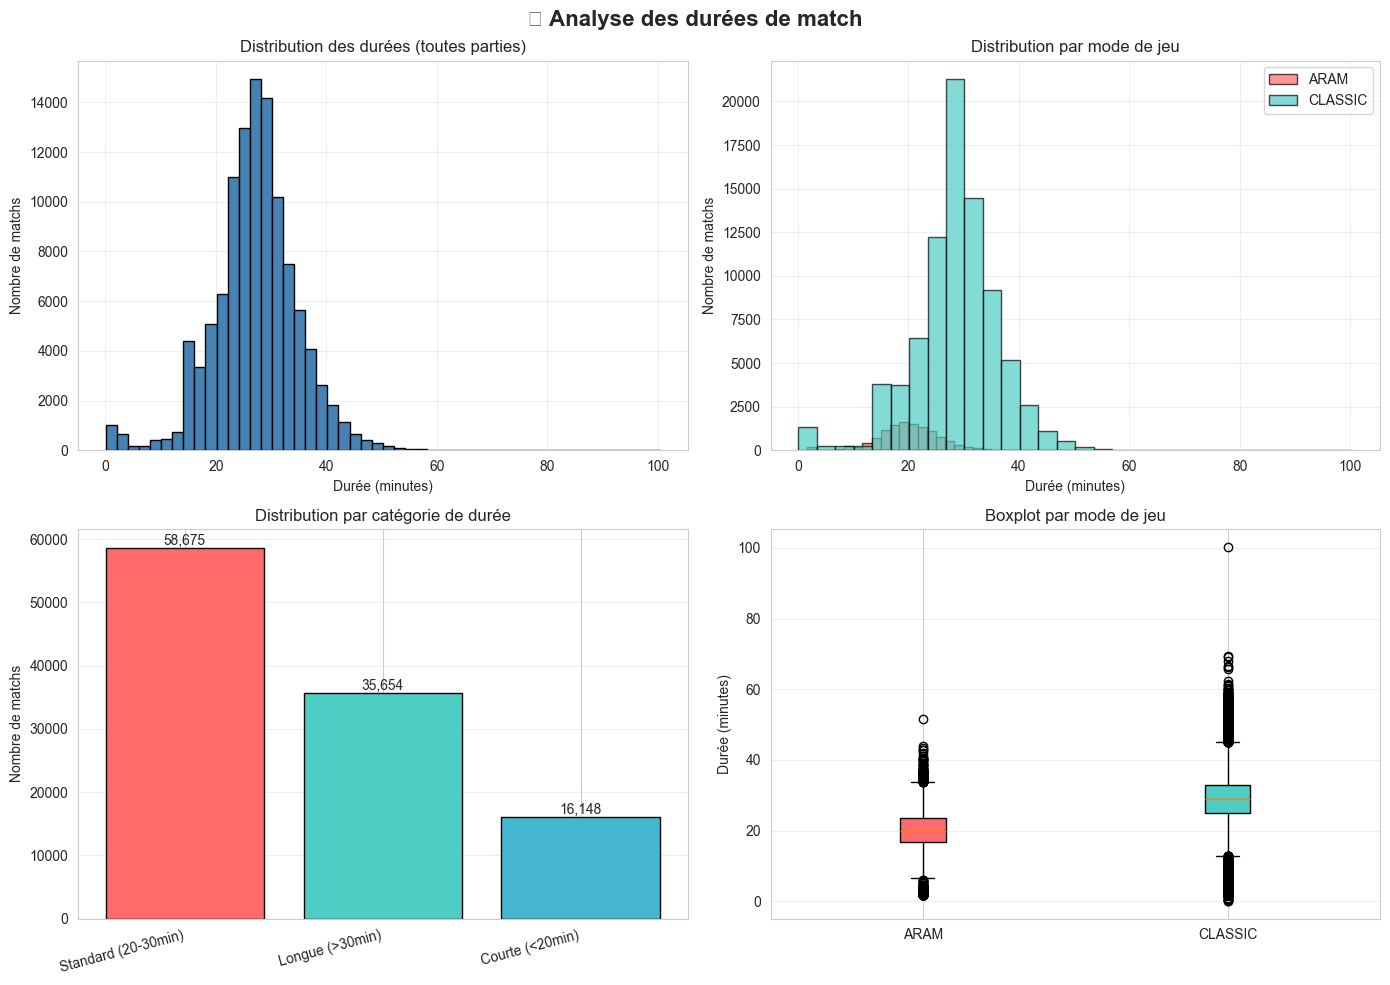


📈 Interprétation:
- ARAM: matchs plus courts (une seule lane, combats constants)
- CLASSIC: distribution plus étalée (stratégies variées)
- Pics autour de 15-20min (surrenders) et 25-35min (matchs complets)


In [10]:
# 1. Distribution des durées de match
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('📊 Analyse des durées de match', fontsize=16, fontweight='bold')

# Histogramme global
axes[0, 0].hist(matches_df['GameDuration']/60, bins=50, color='steelblue', edgecolor='black')
axes[0, 0].set_xlabel('Durée (minutes)')
axes[0, 0].set_ylabel('Nombre de matchs')
axes[0, 0].set_title('Distribution des durées (toutes parties)')
axes[0, 0].grid(alpha=0.3)

# Histogramme par mode
for mode, color in [('ARAM', '#FF6B6B'), ('CLASSIC', '#4ECDC4')]:
    mode_data = matches_df[matches_df['QueueType'] == mode]['GameDuration']/60
    axes[0, 1].hist(mode_data, bins=30, alpha=0.7, label=mode, color=color, edgecolor='black')
axes[0, 1].set_xlabel('Durée (minutes)')
axes[0, 1].set_ylabel('Nombre de matchs')
axes[0, 1].set_title('Distribution par mode de jeu')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Barplot des catégories
duration_counts = matches_df['DurationCategory'].value_counts()
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
bars = axes[1, 0].bar(range(len(duration_counts)), duration_counts.values, color=colors, edgecolor='black')
axes[1, 0].set_xticks(range(len(duration_counts)))
axes[1, 0].set_xticklabels(duration_counts.index, rotation=15, ha='right')
axes[1, 0].set_ylabel('Nombre de matchs')
axes[1, 0].set_title('Distribution par catégorie de durée')
axes[1, 0].grid(alpha=0.3, axis='y')
for bar in bars:
    height = bar.get_height()
    axes[1, 0].text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(height):,}', ha='center', va='bottom')

# Boxplot par mode
mode_data = [matches_df[matches_df['QueueType'] == mode]['GameDuration']/60 for mode in ['ARAM', 'CLASSIC']]
box = axes[1, 1].boxplot(mode_data, labels=['ARAM', 'CLASSIC'], patch_artist=True)
for patch, color in zip(box['boxes'], ['#FF6B6B', '#4ECDC4']):
    patch.set_facecolor(color)
axes[1, 1].set_ylabel('Durée (minutes)')
axes[1, 1].set_title('Boxplot par mode de jeu')
axes[1, 1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n📈 Interprétation:")
print("- ARAM: matchs plus courts (une seule lane, combats constants)")
print("- CLASSIC: distribution plus étalée (stratégies variées)")
print("- Pics autour de 15-20min (surrenders) et 25-35min (matchs complets)")

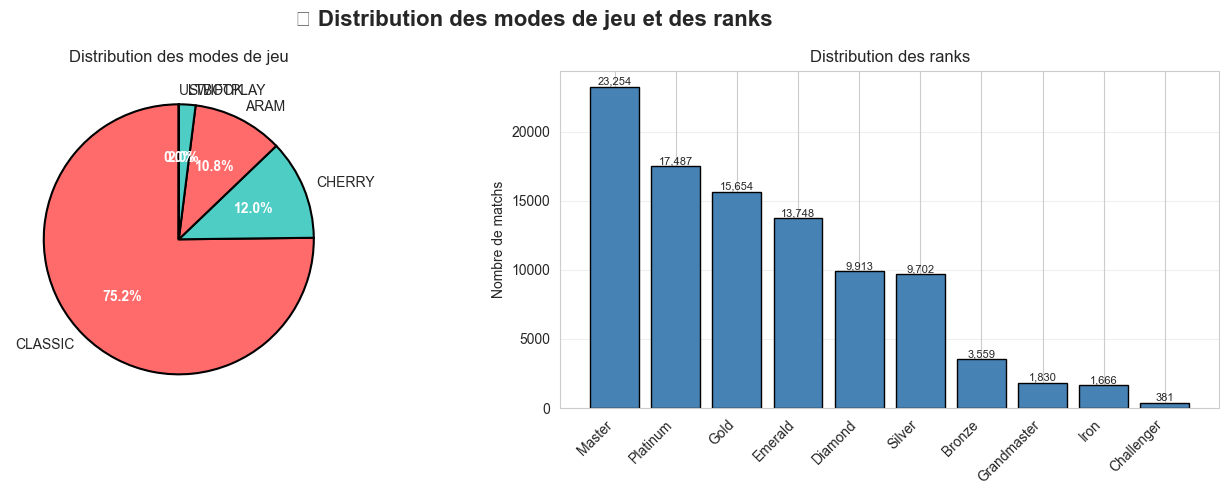


📈 Interprétation:
- Ratio ARAM/CLASSIC: 0.14
- Rank le plus représenté: Master
- Les rangs intermédiaires (Gold-Platinum) sont généralement les plus peuplés


In [12]:
# 2. Distribution des modes de jeu et ranks
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('📊 Distribution des modes de jeu et des ranks', fontsize=16, fontweight='bold')

# Pie chart des modes
mode_counts = matches_df['QueueType'].value_counts()
colors = ['#FF6B6B', '#4ECDC4']
wedges, texts, autotexts = axes[0].pie(mode_counts.values, labels=mode_counts.index, 
                                        autopct='%1.1f%%', colors=colors, startangle=90,
                                        wedgeprops={'edgecolor': 'black', 'linewidth': 1.5})
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
axes[0].set_title('Distribution des modes de jeu')

# Barplot des ranks (pour ranked games uniquement)
if len(ranked_matches) > 0:
    rank_dist = ranked_matches.merge(ranks_df, left_on='RankFk', right_on='RankId')
    rank_counts = rank_dist['RankName'].value_counts()
    
    bars = axes[1].bar(range(len(rank_counts)), rank_counts.values, 
                       color='steelblue', edgecolor='black')
    axes[1].set_xticks(range(len(rank_counts)))
    axes[1].set_xticklabels(rank_counts.index, rotation=45, ha='right')
    axes[1].set_ylabel('Nombre de matchs')
    axes[1].set_title('Distribution des ranks')
    axes[1].grid(alpha=0.3, axis='y')
    
    for bar in bars:
        height = bar.get_height()
        axes[1].text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(height):,}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

print("\n📈 Interprétation:")
print(f"- Ratio ARAM/CLASSIC: {mode_counts['ARAM']/mode_counts['CLASSIC']:.2f}")

print(f"- Rank le plus représenté: {rank_counts.index[0] if len(ranked_matches) > 0 else 'N/A'}")
print("- Les rangs intermédiaires (Gold-Platinum) sont généralement les plus peuplés")

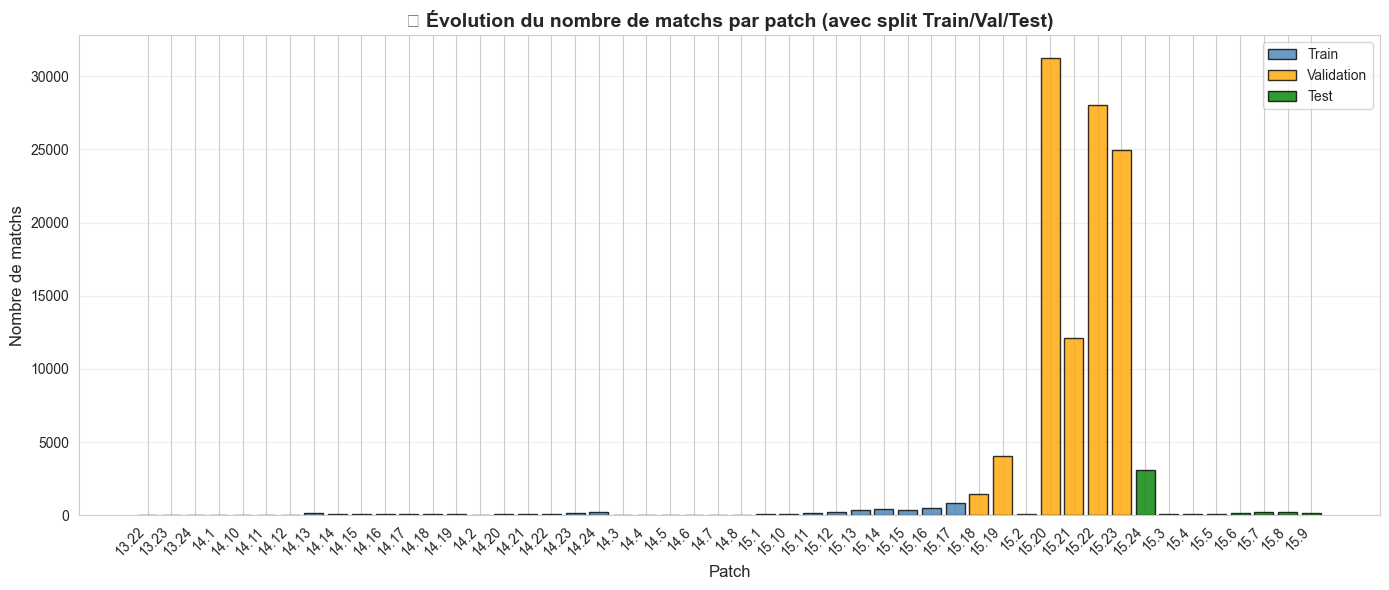


📈 Interprétation:
- Les barres bleues (Train) représentent les patches les plus anciens
- Les barres orange (Validation) et vertes (Test) représentent les patches récents
- Cette séparation temporelle garantit que le modèle apprend sur le passé et prédit le futur
- Les variations de volume peuvent indiquer des périodes de popularité différentes


In [13]:
# 3. Évolution du nombre de matchs par patch (timeline)
patch_timeline = matches_df.groupby('PatchMajor').size().reset_index(name='count')
patch_timeline = patch_timeline.sort_values('PatchMajor')

# Ajouter les marqueurs train/val/test
patch_timeline['Split'] = 'Train'
patch_timeline.loc[patch_timeline['PatchMajor'].isin(val_patches), 'Split'] = 'Validation'
patch_timeline.loc[patch_timeline['PatchMajor'].isin(test_patches), 'Split'] = 'Test'

fig, ax = plt.subplots(figsize=(14, 6))

for split, color in [('Train', 'steelblue'), ('Validation', 'orange'), ('Test', 'green')]:
    data = patch_timeline[patch_timeline['Split'] == split]
    ax.bar(data['PatchMajor'], data['count'], label=split, color=color, edgecolor='black', alpha=0.8)

ax.set_xlabel('Patch', fontsize=12)
ax.set_ylabel('Nombre de matchs', fontsize=12)
ax.set_title('📈 Évolution du nombre de matchs par patch (avec split Train/Val/Test)', 
             fontsize=14, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3, axis='y')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("\n📈 Interprétation:")
print("- Les barres bleues (Train) représentent les patches les plus anciens")
print("- Les barres orange (Validation) et vertes (Test) représentent les patches récents")
print("- Cette séparation temporelle garantit que le modèle apprend sur le passé et prédit le futur")
print("- Les variations de volume peuvent indiquer des périodes de popularité différentes")

## 0.8 - Sauvegarde des données nettoyées (optionnel)

**Objectif :** Sauvegarder les versions nettoyées pour réutilisation rapide.

**Avantages :**
- Éviter de refaire le nettoyage à chaque exécution
- Partager les données nettoyées avec l'équipe
- Garantir la cohérence entre les analyses

In [14]:
# Sauvegarder les données nettoyées (décommenter pour activer)
save_cleaned_data = False  # Mettre à True pour sauvegarder

if save_cleaned_data:
    clean_path = dataset_path / "cleaned"
    clean_path.mkdir(exist_ok=True)
    
    print("💾 Sauvegarde des données nettoyées...")
    
    # Sauvegarder les tables nettoyées
    summoner_match_clean.to_csv(clean_path / "SummonerMatchTbl_clean.csv", index=False)
    match_stats_clean.to_csv(clean_path / "MatchStatsTbl_clean.csv", index=False)
    team_match_clean.to_csv(clean_path / "TeamMatchTbl_clean.csv", index=False)
    
    # Sauvegarder les matchs avec les nouvelles colonnes
    matches_df.to_csv(clean_path / "MatchTbl_enhanced.csv", index=False)
    
    # Sauvegarder les métadonnées de split
    split_metadata = {
        'train_patches': train_patches,
        'val_patches': val_patches,
        'test_patches': test_patches,
        'train_size': len(train_matches),
        'val_size': len(val_matches),
        'test_size': len(test_matches)
    }
    
    import json
    with open(clean_path / "split_metadata.json", 'w') as f:
        json.dump(split_metadata, f, indent=2)
    
    print(f"✅ Données sauvegardées dans: {clean_path}")
else:
    print("ℹ️  Sauvegarde désactivée. Mettre save_cleaned_data=True pour activer.")

ℹ️  Sauvegarde désactivée. Mettre save_cleaned_data=True pour activer.


## 📋 Résumé de la Phase 0 - Bilan et prochaines étapes

### ✅ Ce qui a été accompli :

1. **Chargement des données** : 7 tables chargées (110K+ matchs, 223K+ enregistrements de stats)

2. **Exploration initiale** : 
   - Compréhension de la structure des données
   - Identification des types et dimensions
   - Détection des valeurs manquantes

3. **Nettoyage des anomalies** :
   - ChampionIds invalides supprimés de SummonerMatchTbl
   - Runes à 0 → NaN (données manquantes)
   - Sorts d'invocateur à 0 → NaN
   - Items invalides → NaN
   - Champions invalides supprimés de TeamMatchTbl

4. **Segmentation** :
   - Par mode de jeu (ARAM vs CLASSIC)
   - Par niveau de compétition (Ranked vs Unranked)
   - Par patch (analyse temporelle)
   - Par durée de partie (Courte/Standard/Longue)

5. **Split Train/Val/Test** :
   - **Séparation temporelle par patch** (évite le data leakage)
   - 70% Train / 15% Validation / 15% Test
   - Patches les plus anciens pour l'entraînement, les plus récents pour le test

6. **Visualisations** :
   - Distribution des durées de match
   - Répartition ARAM/CLASSIC
   - Distribution des ranks
   - Timeline des patches avec split visible

### 🎯 Prochaines étapes :

**Phase I - Compréhension de la méta actuelle** :
- Analyse de l'efficacité des champions (winrate par rank, lane, durée)
- Analyse de l'impact des items (items core vs situationnels)

**Phase II - Optimisation du champion** :
- Identification des builds optimaux
- Analyse skill vs pick (performances mécaniques)

**Phase III - Draft et contre-stratégies** :
- Counter-picks
- Champions à bannir

**Phase IV - Stratégies globales de victoire** :
- Facteurs clés de victoire
- Prédiction de l'issue des parties

---

### 💾 Variables importantes créées :

```python
# Tables nettoyées
summoner_match_clean, match_stats_clean, team_match_clean

# Segmentations
aram_matches, classic_matches
ranked_matches, unranked_matches

# Splits
train_matches, val_matches, test_matches
train_match_ids, val_match_ids, test_match_ids

# Tables de référence
champions_df, items_df, ranks_df
```